# Dog Breed I: Keras - VGG16 

## Introduction

I am following the fast.ai course, and this is my take on the Dog Breed competition based on that. In this an other notebooks I will try to get a good score on the Dog Breed competition (say top 50%).

As a starting point, I will fine-tune the VGG16 model, for this, following the example of the dogs vs cat competition of the course. I already have saved the data as suggested. In the data folder I have train, validation and test folders.

In this notebook I will:

* Define the VGG-16 model using Keras, load the weights, and fine-tune it for this competition
* Train the fine-tune version of the model
* Produce a submission file for Kaggle

All this code was added to the libraries utils and vgg16model. But I will leave it here too.

But first let's us load some libraries

In [1]:
%matplotlib inline

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import FileLink

from importlib import reload
import utils; reload(utils)
from utils import *


#import vgg16model; reload(vgg16model)
#from vgg16model import *

Using TensorFlow backend.
/home/benjamin/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Found 360 images belonging to 120 classes.
Found 360 images belonging to 120 classes.


And this is to avoid too many OOM:

In [2]:
limit_mem()

## VGG-model

In [3]:
import keras.backend as K
from keras.layers import Dense, Flatten, Lambda, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPool2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image

This part is just the VGG model definition. I have downloaded the weights for this previously, which I found at
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5

In [4]:
VGG16_PATH = 'models/vgg16_weights_tf_dim_ordering_tf_kernels.h5'

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
def preproc(x):
    x = x - vgg_mean
    return x[:,:,:,::-1]

def conv_block(model, layers, filters):
    for i in range(layers):
        model.add(Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

def fc_block(model, do):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(do))

def vgg16(do):
    model = Sequential()
    
    model.add(Lambda(preproc, input_shape=(224,224,3)))
    
    conv_block(model, 2, 64)
    conv_block(model, 2, 128)
    conv_block(model, 3, 256)
    conv_block(model, 3, 512)
    conv_block(model, 3, 512)
    
    model.add(Flatten())
    fc_block(model, do)
    fc_block(model, do)
    model.add(Dense(1000, activation='softmax'))

    model.load_weights(VGG16_PATH)
    
    return model

def vgg16_dogbreed(do):
    model = vgg16(do)

    model.pop()
    model.add(Dense(120, activation='softmax'))

    return model

In [5]:
model = vgg16_dogbreed(0)

Now that we have the model with the weights loaded, we can fine tune it. Recall that for Dog Breed competition there are 120 categories so:

In [6]:
for layer in model.layers[:-1]: layer.trainable=False
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

## Train the model

Now, we prepare the batches and train the model. In the first run, to verify that everything works, I will use the sample path, then I will subtitute it with the real path. Here is a function to obtain batches:

In [7]:
def get_batch(path, gen=image.ImageDataGenerator(),
              batch_size=4, shuffle=False):
    '''Generate an iterator for batching, and the steps needed in each epoch'''
    iterator = gen.flow_from_directory(path, target_size=(224,224),
                                       batch_size=batch_size,
                                       shuffle=shuffle)
    steps_per_epoch = int(iterator.n/batch_size)
    return iterator, steps_per_epoch

In [8]:
#path = 'data/sample/'
path = 'data/'

In [9]:
batch_size = 64

In [43]:
train_batch, steps_per_epoch = get_batch(path + 'train', batch_size=batch_size, shuffle=True)
valid_batch, validation_steps = get_batch(path + 'valid', batch_size=batch_size)

Found 9254 images belonging to 120 classes.
Found 968 images belonging to 120 classes.


In [11]:
model.compile(Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit_generator(train_batch,steps_per_epoch, epochs=1,
                   validation_data=valid_batch, validation_steps=validation_steps)

Epoch 1/1
145/144 [==============================] - 50s 347ms/step - loss: 3.0896 - acc: 0.3141 - val_loss: 1.5127 - val_acc: 0.5723


In [13]:
model.fit_generator(train_batch,steps_per_epoch, epochs=4,
                   validation_data=valid_batch, validation_steps=validation_steps)

Epoch 1/4
145/144 [==============================] - 46s 317ms/step - loss: 1.1455 - acc: 0.6703 - val_loss: 1.1036 - val_acc: 0.6560
Epoch 2/4
145/144 [==============================] - 46s 316ms/step - loss: 0.7930 - acc: 0.7634 - val_loss: 0.9798 - val_acc: 0.6942
Epoch 3/4
145/144 [==============================] - 46s 316ms/step - loss: 0.6071 - acc: 0.8216 - val_loss: 0.9222 - val_acc: 0.7107
Epoch 4/4
145/144 [==============================] - 46s 316ms/step - loss: 0.4836 - acc: 0.8658 - val_loss: 0.8893 - val_acc: 0.7242


In [14]:
model.save_weights('models/vgg16_fine_tuned_1.h5')

Right now it is overfitting but still improving. I am going to use this as my starting point.

## Create a submission file

Now, to obtain the predictions is easy, but they are not real probabilities of each category, since the model, as far as I understand, tends to be overconfident. Which means we have to adjust the result for that. I designed the following function which tries to accomplish this:

In [15]:
_batch, _  = get_batch('data/sample/valid')
DIC_CLASSES = _batch.class_indices
INV_DIC = {str(v): k for k,v in DIC_CLASSES.items()}


def adj(prediction, top_sum=0.98):
    """Adjust the output of a softmax so that the values are not too extreme"""
    low_bar = 1-top_sum
    adj_pred = np.copy(prediction)
    old_top_sum = np.sum(adj_pred[adj_pred>=low_bar])
    # We scale all the probabilities which are in a nice range, to add up to top_sum
    adj_pred[adj_pred>=low_bar] = (top_sum/old_top_sum)*adj_pred[adj_pred>=low_bar] 
    # And set the rest so that they add up to low_bar.
    adj_pred[adj_pred < low_bar] = low_bar/np.sum(adj_pred < low_bar)
    return adj_pred


test_path = 'data/test/'
def prepare_submission(submission_file, model, top_sum=0.98):
    """Creates the file for the submission.
    submission_file -> filename where to save the submission
    model -> the Keras model which makes the prediction
    top_sum -> to cap the predictions

    returns a pandas DataFrame with the predictions."""
    test_batches, test_steps = get_batch(test_path, batch_size=64, shuffle=False)
    names_of_pics = sorted(os.listdir(test_path+'unknown'))
    predictions = model.predict_generator(test_batches, steps=test_steps)
    test_df = pd.DataFrame()
    test_df['id'] = [name[:-4] for name in names_of_pics]
    test_df.set_index('id', inplace=True)
    probs = np.array([adj(pred, top_sum) for pred in predictions])
    for i in range(len(INV_DIC)):
        test_df[INV_DIC[str(i)]] = np.transpose(probs)[i]
    
    test_df.to_csv(submission_file)
    return test_df

Found 360 images belonging to 120 classes.


In [16]:
model.load_weights('models/vgg16_fine_tuned_1.h5')

In [17]:
test_path = path + 'test/'

In [18]:
test_df = prepare_submission('submissions/new_submissions_1bisbis.csv', model, top_sum=0.98)

Found 10357 images belonging to 1 classes.


In [19]:
test_df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
000621fb3cbb32d8935728e48679680e,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,...,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168
00102ee9d8eb90812350685311fe5890,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,...,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171
0012a730dfa437f5f3613fb75efcd4ce,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,...,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174
001510bc8570bbeee98c8d80c8a95ec1,0.054750,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,...,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180
001a5f3114548acdefa3d4da05474c2e,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,...,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174


In [20]:
FileLink('submissions/new_submissions_1bisbis.csv')

/media/benjamin/Baul/Proyectos/ml_experiments/dogbreed/submissions/new_submissions_1bisbis.csv

This got a score of 1.13167

In [21]:
test_df = prepare_submission('submissions/new_submissions_1bis2bis.csv', model, top_sum=0.8)

Found 10357 images belonging to 1 classes.


/home/benjamin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide


In [22]:
test_df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
000621fb3cbb32d8935728e48679680e,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,...,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681
00102ee9d8eb90812350685311fe5890,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,...,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681
0012a730dfa437f5f3613fb75efcd4ce,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,...,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681
001510bc8570bbeee98c8d80c8a95ec1,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,...,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681,0.001681
001a5f3114548acdefa3d4da05474c2e,0.001695,0.001695,0.001695,0.001695,0.001695,0.001695,0.001695,0.001695,0.001695,0.001695,...,0.001695,0.001695,0.001695,0.001695,0.001695,0.001695,0.001695,0.001695,0.001695,0.001695


In [23]:
FileLink('submissions/new_submissions_1bis2bis.csv')

/media/benjamin/Baul/Proyectos/ml_experiments/dogbreed/submissions/new_submissions_1bis2bis.csv

This got a worse score of 2.63477

## Analysis of the model

In [ ]:
from sklearn.metrics import confusion_matrix

Let's see how the model is doing. Since I can't recognice dog breeds on sight, this is a function to help me:

In [28]:
def example_of_breed(breed):
    file = glob.glob('data/sample/train/' + breed + '/*')[0]
    plot_path(file)

In [31]:
INV_DIC['101']

'siberian_husky'

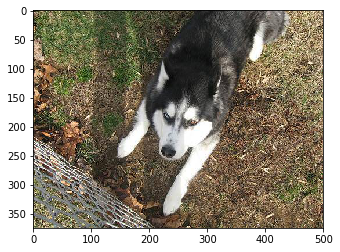

In [32]:
example_of_breed(INV_DIC['101'])

Now, let's see what we get:

In [34]:
predictions = model.predict_generator(valid_batch, validation_steps)

In [35]:
predictions.shape

(968, 120)

In [39]:
validation_files = sorted(glob.glob(path + 'valid/*/*.jpg'))

In [49]:
df = pd.DataFrame()
df['id'] = validation_files
df.set_index('id', inplace=True)

In [50]:
df['label'] = [fname.split('/')[-2] for fname in validation_files]
df['prediction'] = [INV_DIC[str(np.argmax(pred))] for pred in predictions]

In [51]:
df.head()

,label,prediction
id,,
data/valid/affenpinscher/106d7e0df869e7ba9f6d16c5f77ddfb8.jpg,affenpinscher,affenpinscher
data/valid/affenpinscher/4d3bb108c92bf340610878d2f257fb30.jpg,affenpinscher,affenpinscher
data/valid/affenpinscher/5ed432dc19e835ecacfbeea92c7cfc83.jpg,affenpinscher,affenpinscher
data/valid/affenpinscher/6d842ffa6f10d7d5639703028230607c.jpg,affenpinscher,affenpinscher
data/valid/affenpinscher/7d4818d89173768ccccd1fd8fc892d0d.jpg,affenpinscher,affenpinscher


In [52]:
sum(df.label==df.prediction)/len(df)

0.7241735537190083

In [72]:
x = confusion_matrix(df.label.values,df.prediction.values, labels=list(INV_DIC.values()))

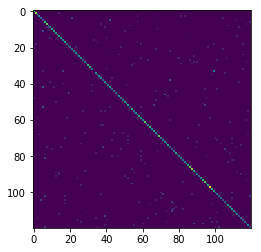

In [73]:
plt.imshow(x)

It is hard to see in there. But there seem to be a missing point in the diagonal.

In [74]:
np.argmin(x.diagonal())

33

In [76]:
np.min(x.diagonal())

0

In [75]:
list(INV_DIC.values())[33]

'collie'

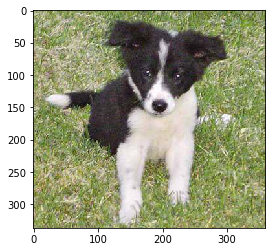

In [83]:
example_of_breed('collie')

In [84]:
np.argmax(x.diagonal())

97

In [85]:
np.max(x.diagonal())

12

In [86]:
list(INV_DIC.values())[97]

'scottish_deerhound'

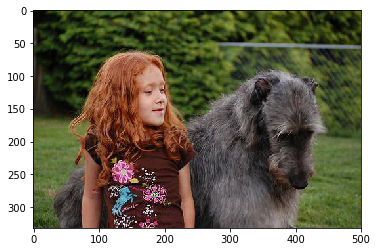

In [87]:
example_of_breed('scottish_deerhound')